In [2]:
import pandas as pd
import spacy
import umap
import numpy as np
from sklearn.cluster import KMeans
import en_core_web_lg
from sklearn.metrics import silhouette_samples, silhouette_score
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

from ipynb.fs.full.data_processing import format_raw_df, get_split_by_author, add_text_features_to_df, get_vectorized_series, train_vectorizer

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = add_text_features_to_df(df.loc[df['is_question']].copy())

train_author, test_author = get_split_by_author(df[df['is_question']])

In [3]:
nlp = en_core_web_lg.load(disable = ['parser','tagger','ner','textcat'])
train_author['vectors'] = train_author['full_text'].apply(lambda x: nlp(x).vector)

vectorized_features = np.vstack(train_author['vectors'])

In [4]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

Text(0.5, 1.0, 'UMAP Projection of questions, colored by clusterss')

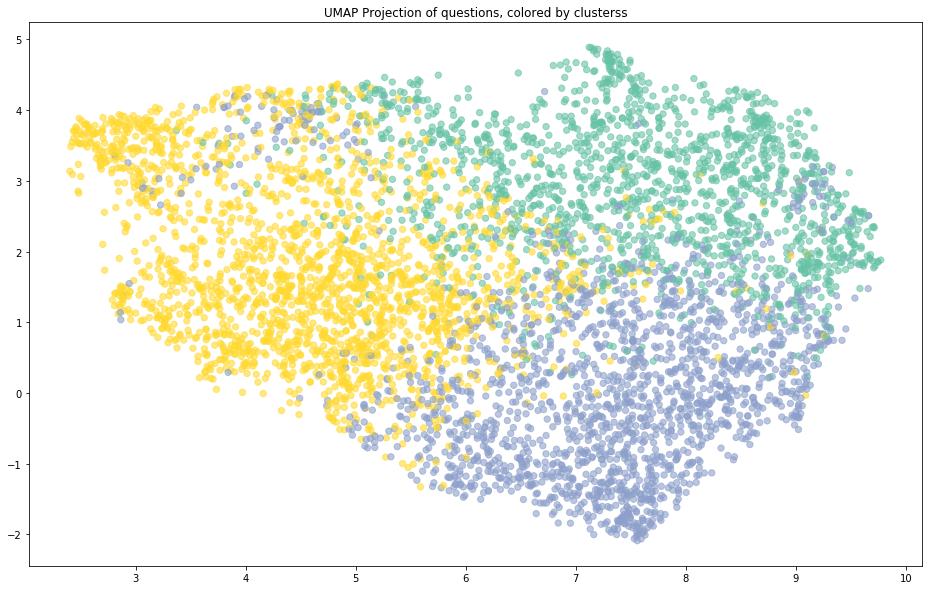

In [5]:
n_clusters = 3
cmap = plt.get_cmap('Set2')

fig = plt.figure(figsize = (16,10))

clus = KMeans(n_clusters = n_clusters, random_state = 10)
clusters = clus.fit_predict(vectorized_features)

plt.scatter(umap_features[:,0], umap_features[:,1], 
           c = [cmap(x/n_clusters) for x in clusters], s=40, alpha = 0.6)

plt.title('UMAP Projection of questions, colored by clusterss')

For N Clusters =  2 The Average silhoutte score is : 0.16960822
(2, 300)
For N Clusters =  3 The Average silhoutte score is : 0.07632612
(3, 300)
For N Clusters =  4 The Average silhoutte score is : 0.06380808
(4, 300)
For N Clusters =  5 The Average silhoutte score is : 0.05656057
(5, 300)
For N Clusters =  6 The Average silhoutte score is : 0.03620183
(6, 300)


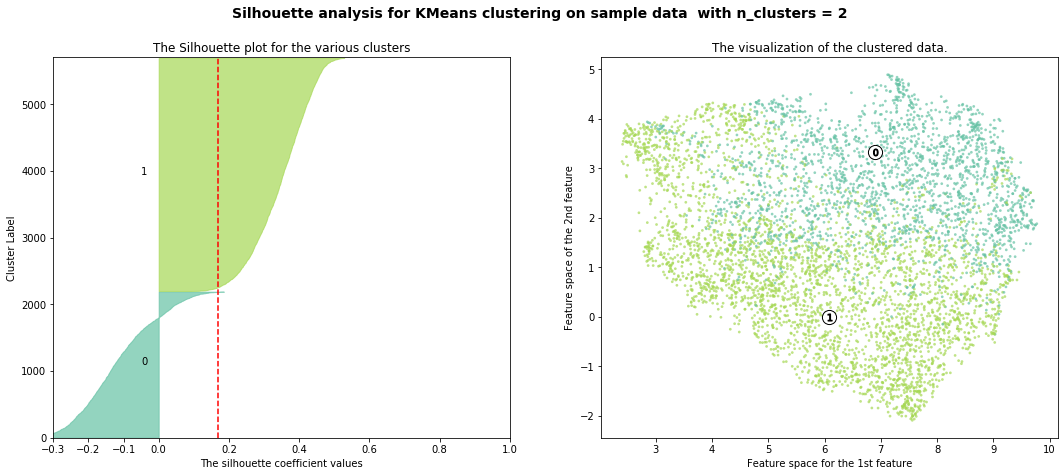

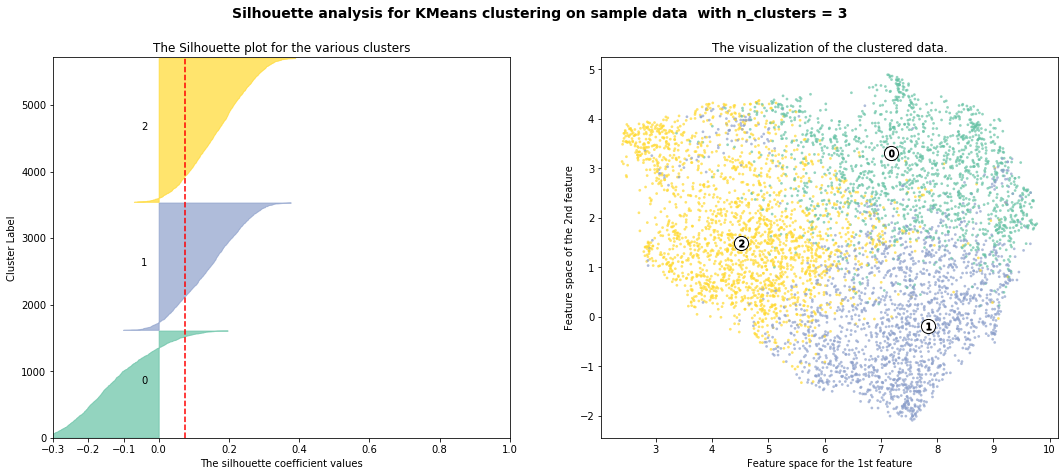

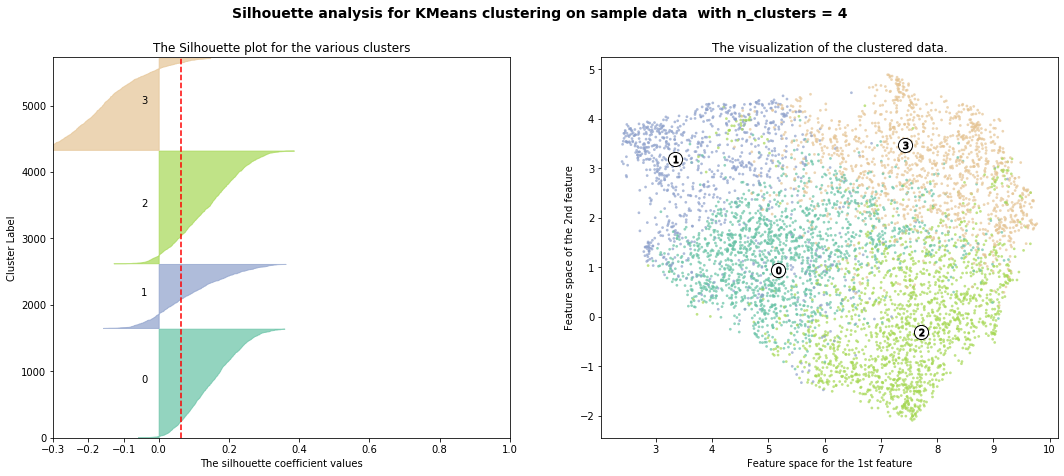

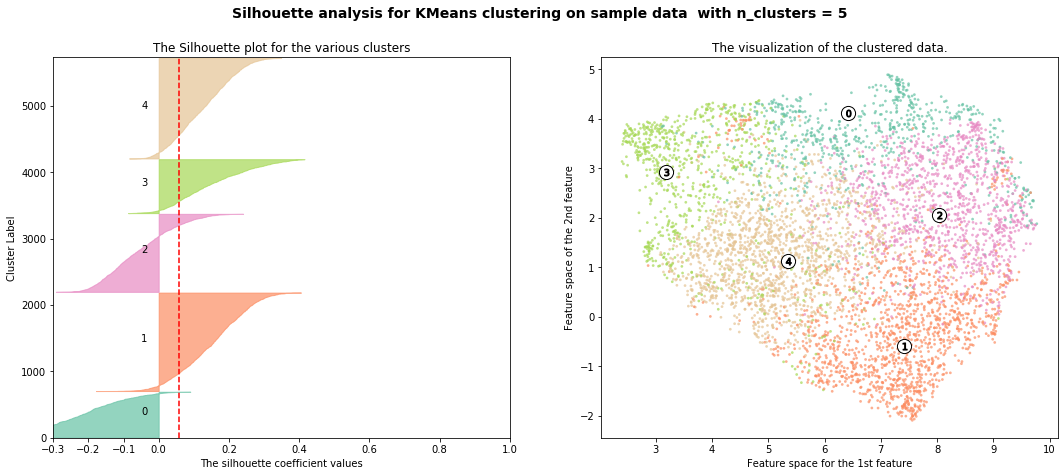

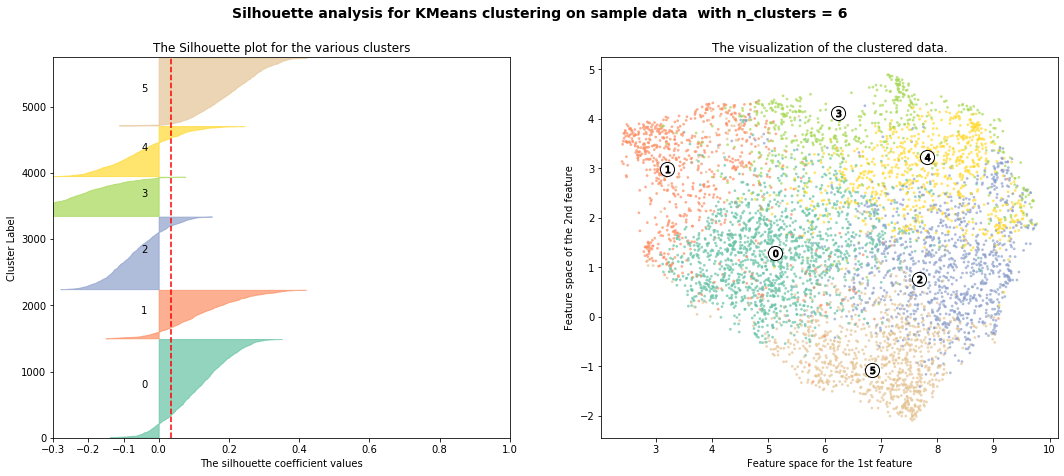

In [26]:
range_n_clusters = [2,3,4,5,6]

to_clus = vectorized_features

for n_clusters in range_n_clusters: 
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(18,7)
    
    ax1.set_xlim([-.3,.4])
    ax1.set_ylim([0, len(to_clus)+ (n_clusters+1)*10])
    
    clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(to_clus)
    
    silhouette_avg = silhouette_score(to_clus, cluster_labels, metric = 'cosine')
    print('For N Clusters = ', n_clusters, 
         'The Average silhoutte score is :', silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(to_clus, cluster_labels, metric = 'cosine')
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower+size_cluster_i
        
        color = cmap(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor = color, edgecolor = color, alpha = 0.7)
        
        #labeling the sihouette plots with thier cluster numbers at the middle
        ax1.text(-0.05, y_lower+0.5*size_cluster_i, str(i))
        
        #compute the new y_lower for the next plot
        y_lower = y_upper + 10 #10 for 0 samples
        
    ax1.set_title('The Silhouette plot for the various clusters')
    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster Label')
    
    #the vertical line for average silhouette score of all values
    ax1.axvline(x = silhouette_avg, color = 'red', linestyle = '--') #clear the yaxis labels/ticks
    ax1.set_xticks([-0.3,-0.2,-0.1,0,0.2,0.4,0.6,0.8, 1])
    
    #2nd plot for showing the actual clusters formed
    
    colors = cmap(cluster_labels.astype(float)/n_clusters)
    ax2.scatter(umap_features[:,0], umap_features[:, 1], marker = '.', s=30, lw = 0, alpha = 0.7, 
               c = colors, edgecolor = 'k')
    
    #labeling the clusters
    centerss = clusterer.cluster_centers_
    print(centerss.shape)
    centers = umap_embedder.transform(centerss)
    
    #draw white circles at the cluster centers
    ax2.scatter(centers[:, 0], centers[:,1], marker = 'o', c = 'white', alpha = 1, s=200, edgecolor = 'k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker = '$%d$' % i, alpha = 1, s= 50, edgecolor = 'k')
        
    ax2.set_title('The visualization of the clustered data.')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space of the 2nd feature')
    
    plt.suptitle(('Silhouette analysis for KMeans clustering on sample data '
                 " with n_clusters = %d" % n_clusters), 
                fontsize = 14, fontweight = 'bold')